In [11]:
import sys
import os

sys.path.append(os.path.join(os.getcwd(), ".."))


import torch
import torch.nn as nn
import torchinfo
from tqdm.notebook import tqdm 

from torchvision.datasets import Caltech101
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms


from vision_transformer.VisionTransformer import ViT
from src.read_config import read_config

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [12]:
config = read_config(config_path='../configs', config_name='architecture_2.yaml')
config

{'inputs': {'img_size': 96, 'in_channels': 3}, 'params': {'patch_size': 8, 'd_model': 512, 'dropout_rate': 0.5, 'n_encoder_blocks': 2, 'n_heads': 4, 'ff_size': 1024}}

In [13]:
class TransformerClassifier(nn.Module): 
    def __init__(self, n_classes, img_size: int, in_channels: int, transformer_config): 
        super().__init__()
        
        self.n_classes = n_classes
        self.img_size = img_size
        self.in_channels = in_channels
        self.transformer_config = transformer_config
        
        self.vit = ViT(img_size=img_size, in_channels=in_channels, **self.transformer_config)

        self.classifier = nn.Sequential(
            nn.Linear(self.vit.d_model, self.n_classes), 
            nn.ReLU(), 
        )
        
    def forward(self, x): 
        embeddins = self.vit(x)
        logits = self.classifier(embeddins)
        
        return logits

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((96, 96))
])

dataset = Caltech101(root='./data', download=True, transform=transform)
filtered_indices = []
for img_id in range(len(dataset)):
    img, label = dataset[img_id]
    if img.shape[0] == 3:
        filtered_indices.append(img_id)

filtered_dataset = Subset(dataset, filtered_indices)
train_loader = DataLoader(filtered_dataset, batch_size=10, shuffle=True)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.038452845..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.006098952..1.0000002].


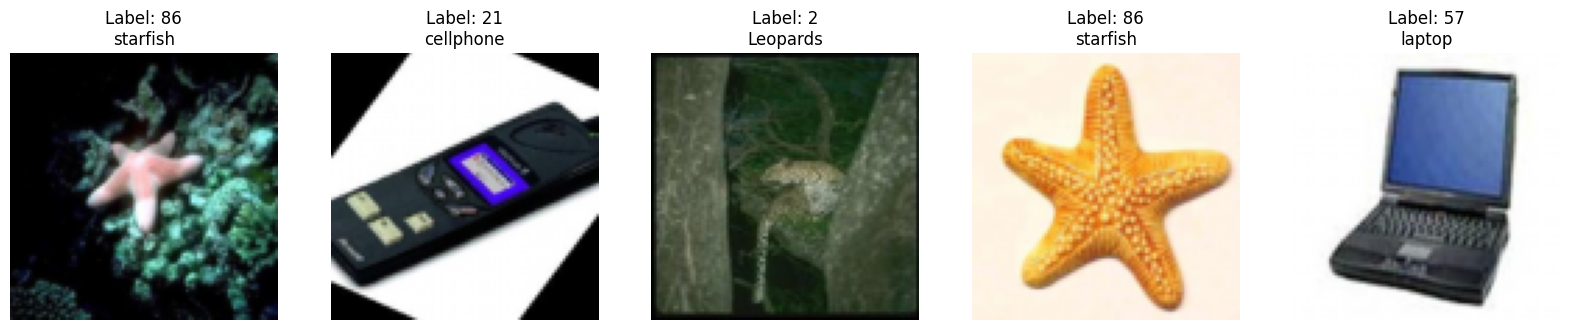

In [15]:
def plot_images(images, labels, text_labels, n_images=5):
    fig, axes = plt.subplots(1,min(n_images, len(labels)), figsize=(20, 20))
    for i, (img, label) in enumerate(zip(images, labels[:min(n_images, len(labels))])):
        img = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        axes[i].imshow(img)
        axes[i].set_title(f'Label: {label}\n{text_labels[label]}')
        axes[i].axis('off')
    plt.show()
    
for images, labels in train_loader:
    plot_images(images, labels, dataset.categories, n_images=5)
    break

In [16]:
model = TransformerClassifier(n_classes=101, img_size=96, in_channels=3, transformer_config=config['params'])
model.load_state_dict(torch.load('architecture_2.pth', weights_only=True))
model.eval()

TransformerClassifier(
  (vit): ViT(
    (embedder): PatchEmbedder(
      (embedder): Conv2d(3, 512, kernel_size=(8, 8), stride=(8, 8))
    )
    (position_encoder): PositionalEncoding()
    (encoder): Encoder(
      (layers): ModuleList(
        (0-1): 2 x EncoderBlock(
          (attention_block): MultiHeadAttention(
            (query_transform): Linear(in_features=512, out_features=512, bias=True)
            (key_transform): Linear(in_features=512, out_features=512, bias=True)
            (value_transform): Linear(in_features=512, out_features=512, bias=True)
            (w_o): Linear(in_features=512, out_features=512, bias=True)
            (dropout): Dropout(p=0.5, inplace=False)
          )
          (feed_forward_block): FeedForwardBlock(
            (feed_forward): Sequential(
              (0): Linear(in_features=512, out_features=1024, bias=True)
              (1): ReLU()
              (2): Dropout(p=0.5, inplace=False)
              (3): Linear(in_features=1024, out_featur

In [55]:
def interpret_attention(transformer, image):
    assert len(image.shape) == 3, "You cannot pass batch"
    assert image.shape[0] == transformer.in_channels
    # assert image.shape[1] == image.shape[2] == transformer.img_size

    image = image.unsqueeze(0)
    transformer(image)

    attn_block = transformer.encoder.layers[-1].attention_block    
    attention_scores = attn_block.get_last_compute()[0][:, 0, 1:]
    
    attentions_transformed = attention_scores.view(-1, image.shape[2] // transformer.embedder.patch_size, 
                                                                                                image.shape[3] // transformer.embedder.patch_size) 
    print(attentions_transformed.shape)
    
    
    n_heads = attentions_transformed.shape[0]
    plt.figure(figsize=(10, 10))
    
    plt.subplot(3, n_heads, 1)
    plt.imshow(image[0].permute(1, 2, 0).numpy())
    
    for i in range(n_heads):
        plt.subplot(3, n_heads, n_heads + i+1)
        plt.imshow(attentions_transformed[i], cmap='inferno')
        plt.title(f"Head n: {i+1}")

    attn_aggr = attentions_transformed.mean(axis=0)
    plt.subplot(3, n_heads, n_heads * 2 +2)
    plt.imshow(attn_aggr, cmap='inferno')
    plt.title(f"Aggregated")
    plt.show()


Faces
torch.Size([4, 12, 12])


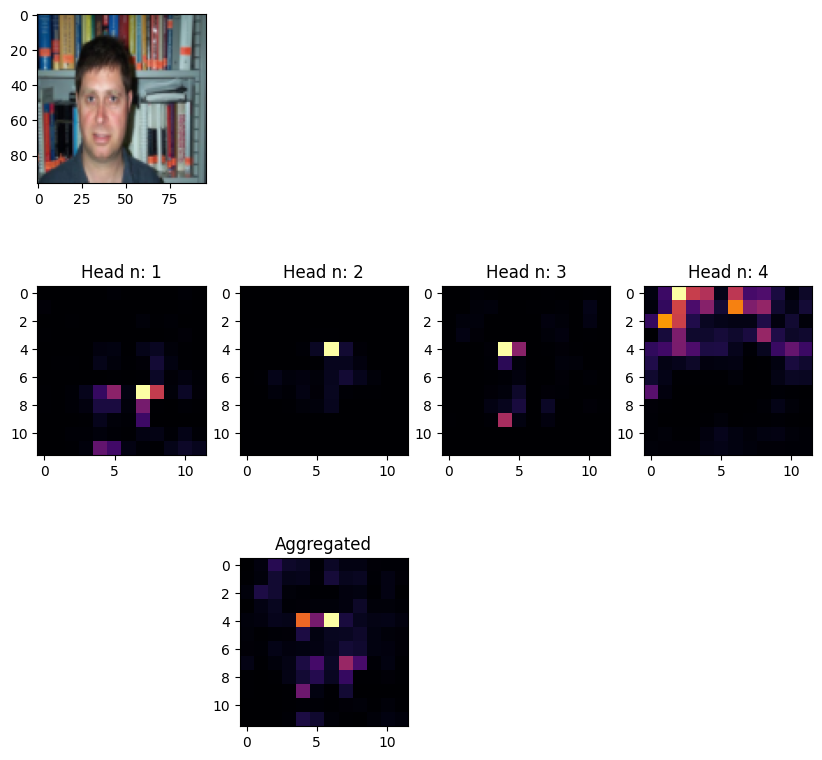

Leopards
torch.Size([4, 12, 12])


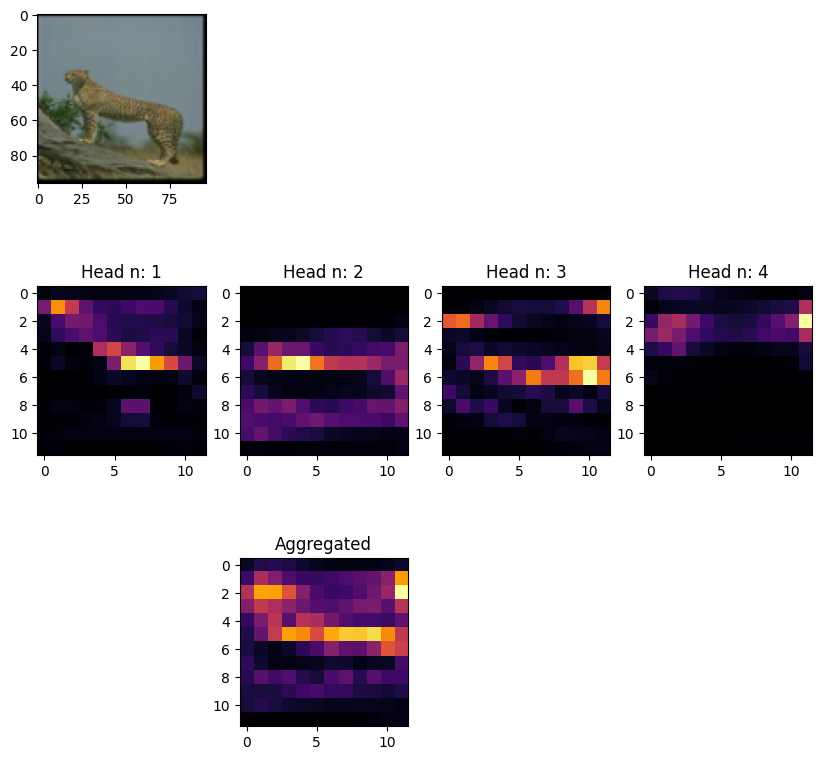

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


airplanes
torch.Size([4, 12, 12])


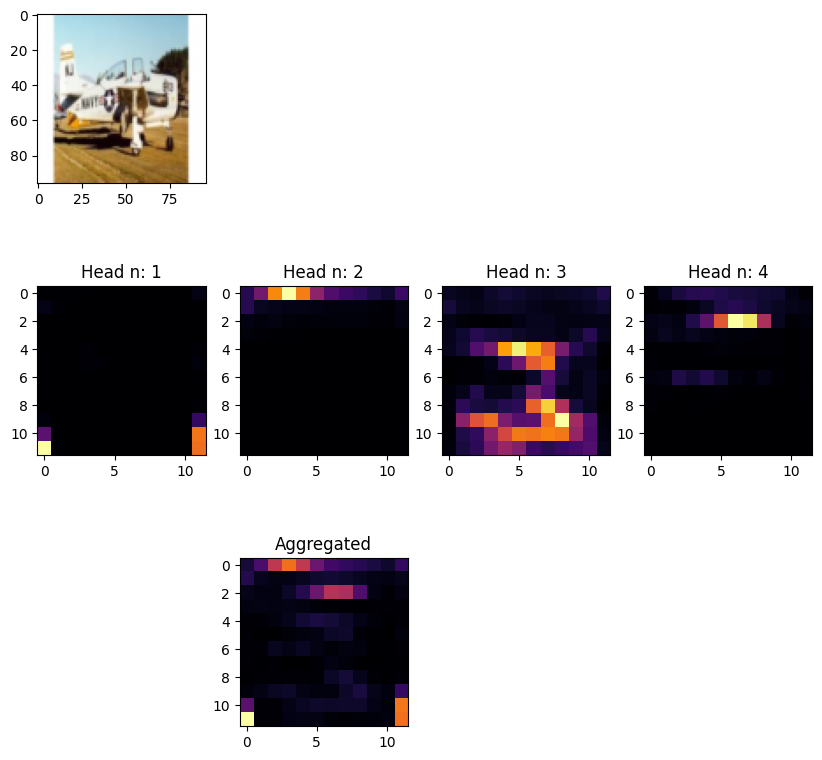

bonsai
torch.Size([4, 12, 12])


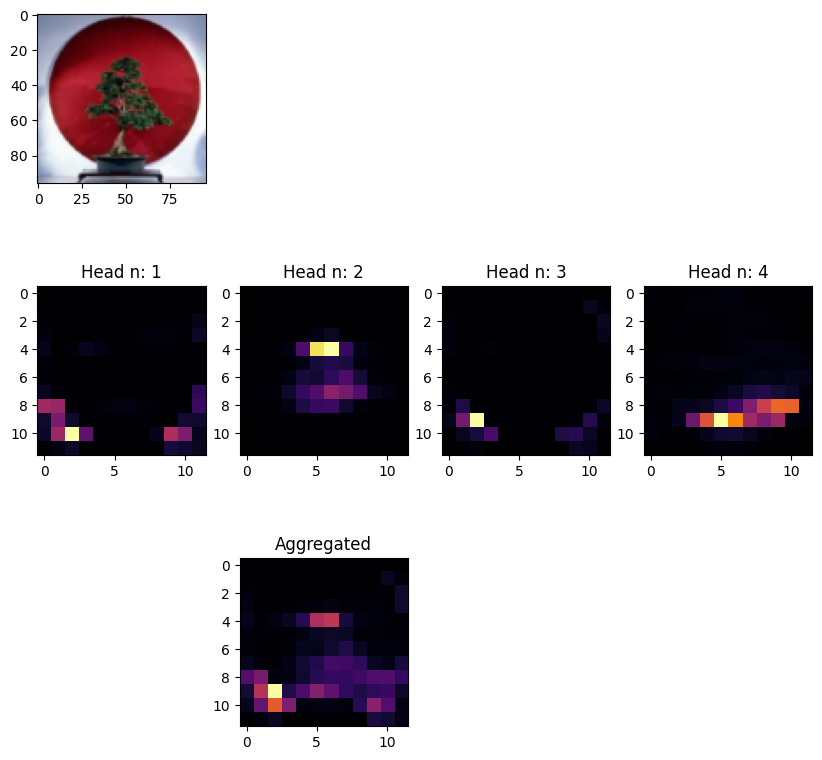

In [53]:
for index in [1, 1000, 2000, 3000]:
    image_data = filtered_dataset[index]
    print(dataset.categories[image_data[1]])
    img = image_data[0].permute(1, 2, 0).numpy()

    interpret_attention(model.vit, image_data[0])

torch.Size([4, 57, 87])


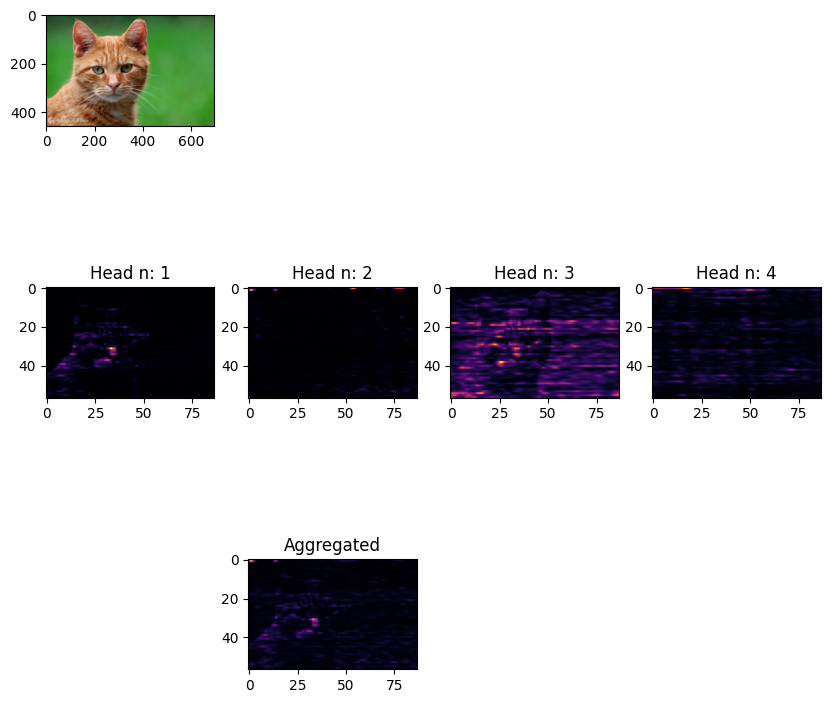

In [56]:
from PIL import Image

image = Image.open("data/testing_images/cat.jpg")
transform = transforms.Compose([transforms.PILToTensor(), transforms.Resize((456, 696))])
img_tensor = transform(image)/255

interpret_attention(model.vit, img_tensor)